# Case Background & Key Questions	

Flatiron Health Insurance (FHI) is a growing private healthcare insurance provider founded on the premise that using data and analytics can improve the health insurance industry by providing better care and offerings to its patients. Every year, the Center for Disease Control (CDC) conducts surveys to understand the latest demographic, health, and fitness trends. You have been tasked with analyzing the recently published results of his years’ survey and providing your recommendations back to the Chief Analytics Officer and Chief Marketing Officer. You have been assigned the task of taking a first look at the data and beginning to answer several key questions:
											 								
1)  How does health status, represented by average number of days with bad physical health in the past month (PHYSHLTH), differ by state? Also provide an indication of distribution using whatever statistics you find suitable.
 												 								
2)  Digging deeper into the data, what are some factors that impact health (i.e. demographics, behaviors, previous illness, etc.)?	
						 						
To get you started, the IT department formatted the data set into a tab delimited text file for only NY, NJ, and CT (FHI’s primary markets) called `case_studey.csv`. Below you will find a list of steps/questions that you will need to take in your investigation. The first part of the notebook will be focused on cleaning up your data and vidualizing it.  The second part of the data set will be focused on performing statistical tests to make statements with statistical significance.  


In [1]:
import math
import numpy as np
import pandas as pd

import scipy.stats as stats
from scipy.stats import chi2_contingency
from scipy.stats import chi2

from statsmodels.formula.api import ols
import statsmodels.api as sm

import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import style
style.use('dark_background')

import seaborn as sns
sns.set_style('darkgrid')

# pd.read_csv('case_study.csv')

In [2]:
#Load our dataframe account for the index columns
df = pd.read_csv('case_study.csv', index_col=0)

/Users/eric/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (171) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
df.head()

,_STATE,FMONTH,IDATE,IMONTH,IDAY,IYEAR,DISPCODE,SEQNO,_PSU,CTELENM1,...,_PA300R2,_PA30021,_PASTRNG,_PAREC1,_PASTAE1,_RFSEAT2,_RFSEAT3,_FLSHOT6,_PNEUMO2,_AIDTST3
49938,9.0,5.0,5172017,5,17,2017,1200.0,2017000001,2.017000e+09,NaN,...,2.0,2.0,2.0,4.0,2.0,1.0,1.0,NaN,NaN,1.0
49939,9.0,2.0,2142017,2,14,2017,1200.0,2017000002,2.017000e+09,NaN,...,1.0,1.0,1.0,1.0,1.0,2.0,2.0,NaN,NaN,2.0
49940,9.0,1.0,1292017,1,29,2017,1200.0,2017000003,2.017000e+09,NaN,...,3.0,2.0,1.0,3.0,2.0,1.0,1.0,NaN,NaN,2.0
49941,9.0,7.0,9112017,9,11,2017,1200.0,2017000004,2.017000e+09,NaN,...,2.0,2.0,2.0,2.0,2.0,1.0,1.0,NaN,NaN,1.0
49942,9.0,5.0,7182017,7,18,2017,1200.0,2017000005,2.017000e+09,NaN,...,2.0,2.0,1.0,1.0,1.0,1.0,1.0,NaN,NaN,2.0


In [4]:
# Quickly check to see the size of our DF, both rows and columns
df.shape

(34545, 358)

**PHYSHLTH** is the column we are interested in for this analysis, so let's start to investigate the column. Since we have a data cookbook, a.k.a. data dictionary) we want to start there before looking at the code.

## 1. Handle the non-normal values

As you can see from the data dictionary, there are a number of responses that are coded with values that could throw off our descriptive statistics.  Let's clean up by mapping the responses to a more appropriate value, and handling any missing values.  

In [5]:
#your code here
zero_dict = {88:0, 77: np.nan, 99: np.nan}
df['PHYSHLTH'].replace(zero_dict, inplace=True)

In [6]:
# Rename states to state abv.
df['_STATE'].replace(9.0, 'CT', inplace=True)
df['_STATE'].replace(34.0, 'NJ', inplace=True)
df['_STATE'].replace(36.0, 'NY', inplace=True)

In [7]:
# Create separate databases for each state
df_ct = df.set_index('_STATE').loc['CT']
df_nj = df.set_index('_STATE').loc['NJ']
df_ny = df.set_index('_STATE').loc['NY']

## 2. Generate the descriptive statistics

Now that our target variable is cleaned up lets calculate the descriptive statistics, generate a graph that quickly shows those statistics, and generate a graph shows the distribution of the data.

In [8]:
df['PHYSHLTH'].describe()

count    33747.000000
mean         4.085341
std          8.513293
min          0.000000
25%          0.000000
50%          0.000000
75%          3.000000
max         30.000000
Name: PHYSHLTH, dtype: float64

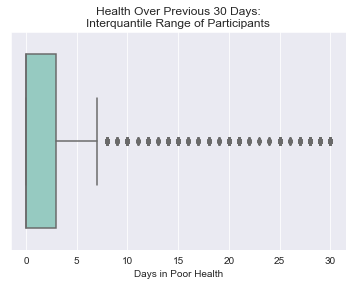

In [9]:
# Plot boxplot of PHYSHLTH values
sns.boxplot(df['PHYSHLTH']).set(
    title='Health Over Previous 30 Days:\nInterquantile Range of Participants',
    xlabel='Days in Poor Health')

plt.show()

In [10]:
# Graphic the distribution of data

In [11]:
# # Seaborn
# sns.distplot(df['PHYSHLTH'], kde=False).set(
#     title='Health Over Previous 30 Days', xlabel='Days in Poor Health',
#     ylabel='Participants')

# plt.show()

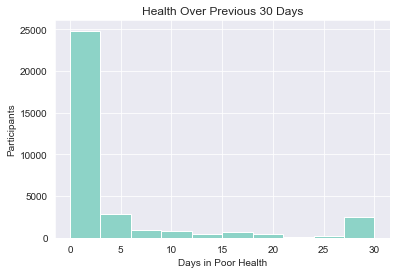

In [12]:
# matplotlib
df['PHYSHLTH'].plot(kind='hist')
plt.title('Health Over Previous 30 Days')
plt.xlabel('Days in Poor Health')
plt.ylabel('Participants')

plt.show()

## 3. Generate a graphic that compares the average number of sick days for each state. 

In [13]:
# Code to calculate the average number of sick days by state
avg_sick_days = df.groupby('_STATE')['PHYSHLTH'].mean()
avg_sick_days

_STATE
CT    3.688562
NJ    4.380957
NY    4.148030
Name: PHYSHLTH, dtype: float64

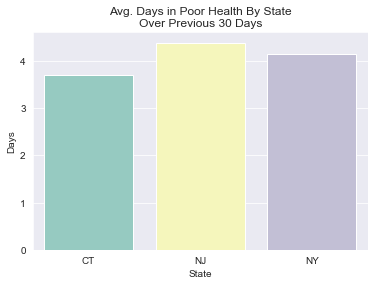

In [14]:
# Seaborn
sick_days_plot = (list(avg_sick_days.keys()), list(avg_sick_days[0:3]))
sns.barplot(sick_days_plot[0], sick_days_plot[1]).set(
    title='Avg. Days in Poor Health By State\nOver Previous 30 Days',
    xlabel='State', ylabel='Days')

plt.show()

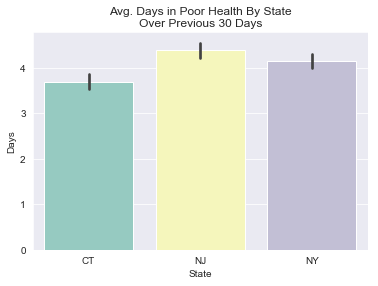

In [15]:
# Seaborn ---Why does this work?---
sns.barplot(df['_STATE'], df['PHYSHLTH'], data=df).set(
    title='Avg. Days in Poor Health By State\nOver Previous 30 Days',
    xlabel='State', ylabel='Days')

plt.show()

In [16]:
# Graphic showing the histogram of data

In [17]:
df.groupby('_STATE').mean()

,FMONTH,IDATE,IMONTH,IDAY,IYEAR,DISPCODE,SEQNO,_PSU,CTELENM1,PVTRESD1,...,_PA300R2,_PA30021,_PASTRNG,_PAREC1,_PASTAE1,_RFSEAT2,_RFSEAT3,_FLSHOT6,_PNEUMO2,_AIDTST3
_STATE,,,,,,,,,,,,,,,,,,,,,
CT,6.183037,6.462077e+06,6.308651,15.140820,2017.003211,1119.418209,2.017005e+09,2.017005e+09,1.0,1.000543,...,2.819135,2.600680,2.465905,3.464110,2.767378,1.841235,1.873536,2.442057,2.539013,1.942721
NJ,7.858387,8.220029e+06,8.060044,15.796720,2017.000342,1114.895798,2.017006e+09,2.017006e+09,1.0,1.000133,...,2.826785,2.540571,2.364025,3.474291,2.675692,1.707892,1.743765,2.166591,2.248413,1.896568
NY,6.792228,7.070543e+06,6.920892,14.763409,2017.000490,1120.948649,2.017006e+09,2.017006e+09,1.0,1.000735,...,3.067108,2.801453,2.608784,3.705445,2.950445,1.994775,2.045718,2.562725,2.582519,1.705739


In [18]:
#df.groupby(['_STATE', 'PHYSHLTH']).sum()

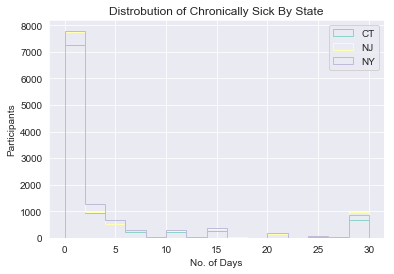

In [19]:
# matplotlib
df.groupby('_STATE')['PHYSHLTH'].plot(kind='hist',histtype='step',bins=15)
plt.legend(labels=['CT','NJ','NY'])
plt.title('Distrobution of Chronically Sick By State')
plt.xlabel('No. of Days')
plt.ylabel('Participants')
plt.show()

In [20]:
# Seaborn ???

## 4. Turn the number of sick days into a classification of of chronically sick people.  

Chronically sick people account for a significant proportion of the costs for health insurers. If we can identify what leads people to be chronically sick, we can address them with specific treatments.



In [21]:
# code to create new colum for chronically sick
# solutions branch used chronically sick as >10 days sick
# use np.where, create column with 0,1 values


In [22]:
# Without np.where ---Why are values different?---
test = (df['PHYSHLTH'] >= 10)

df[test]['PHYSHLTH'].describe()

count    5077.000000
mean       22.513098
std         8.095378
min        10.000000
25%        15.000000
50%        27.000000
75%        30.000000
max        30.000000
Name: PHYSHLTH, dtype: float64

In [23]:
# With np.where ---Why are values different?---
chronically_sick = np.where(df['PHYSHLTH'] > 10, 1, 0)
df['CHRONSICK'] = chronically_sick

for index, row in df[['PHYSHLTH']].head().iterrows():
    print (row)

PHYSHLTH    0.0
Name: 49938, dtype: float64
PHYSHLTH    0.0
Name: 49939, dtype: float64
PHYSHLTH    2.0
Name: 49940, dtype: float64
PHYSHLTH    0.0
Name: 49941, dtype: float64
PHYSHLTH    0.0
Name: 49942, dtype: float64


## 5. Create a graphic that compares the percentage of people labeled as 'sick' in each state. 

In [24]:
# Code to calculate averages per state

In [25]:
# Using main df
df.groupby('_STATE')['CHRONSICK'].mean()

_STATE
CT    0.112864
NJ    0.136317
NY    0.125316
Name: CHRONSICK, dtype: float64

In [26]:
# # Using state dfs
# test2 = [df_ct['CHRONSICK'].mean(),
#         df_nj['CHRONSICK'].mean(),
#         df_ny['CHRONSICK'].mean()]

# test2

In [27]:
# Create graphic to compare chronically sick by state

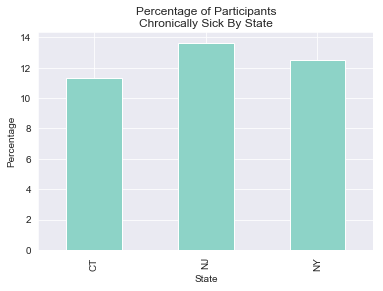

In [28]:
(df.groupby('_STATE')['CHRONSICK'].mean()*100).plot(kind='bar')
plt.title('Percentage of Participants\nChronically Sick By State')
plt.xlabel('State')
plt.ylabel('Percentage')
plt.show()

## 6. Independent Variables (categorical)

Does smoking affect the number of days people feel physically ill? 
Let's take the column `SMOKDAY2` and start to prepare it so that we can see how it is possibly correlated to `PHYSHLTH`. When cleaning this data you will find that many respondents were not asked that question. read the codebook to understand why, and use that information when cleaning up your data. I.E, you will need to process two columns in order to create a new column of smokers.

1. Clean up the values.
2. Calculate the descriptive statistics of the variable.
3. Generate a histogram for the variable.
4. Generate graphics that show how the responses to this variable might differ by state.
5. Generate a graphic that compares the physical health of the different groups of 'smokers'.

In [29]:
df['SMOKE100'].value_counts()

2.0    19087
1.0    13795
7.0      174
9.0       51
Name: SMOKE100, dtype: int64

In [30]:
df2 = df

In [31]:
df2['SMOKE100_NO'] = np.where(df['SMOKE100'] == 2.0, 1, 0)
df2['SMOKE100_NA'] = np.where(df['SMOKE100'].isin([7.0, 9.0]), 1, 0)

In [32]:
# your code here

In [33]:
# code to graph those proportion of differen smoking groups using matplotlib


In [34]:
# your code here

In [35]:
#graph showing the breakdown of smokers per state

In [36]:
# code to graph these averages sick days for each category of smoking status

## 7. Independent Variables (continuous):

Does the amount of days a person drinks affect the number of days they feel physically ill?
To investigate this, let's look at a continuous variable (ALCDAY5) and see how that might impact a person's health. 

1. Clean up the values.
2. Calculate the descriptive statistics of the variable.
3. Generate a histogram for the variable.
4. Generate graphics that show how the responses to this variable might differ by state.
5. Calculate the correlation coefficient between `PHYSHLTH` and `ALCDAY5`.
5. Generate a graphic that shows the possible relationship between `PHYSHLTH` and `ALCDAY5`.

In [37]:
# code here to clean up the ALCDAY5 responses


In [38]:
#descriptive statistics of cleaned data

In [39]:
# graphic showing the histogram of data


In [40]:
# code to calculate averages per state


In [41]:
# Code to calculate correlation of between number of dirnks of number of days physically ill

## 8. Statistical Inference


- Create a 95% confidence interval for the population mean of physically ill days.

In [42]:
# Set Physical Health DF
physhlth_mean = df['PHYSHLTH'].mean()

# Confidence Interval
physhlth_low = round(physhlth_mean - 1.96*(8.5/(33747**.5)), 2)
physhlth_high = round(physhlth_mean + 1.96*(8.5/(33747**.5)), 2)
(physhlth_low, physhlth_high)

(3.99, 4.18)

In [95]:
# pop mean is between conf interval

Create a 95% confidence interval for the true proportion of chronically sick people.

In [43]:
# x bar, n, std
chronsick_mean = df['CHRONSICK'].mean()
chronsick_sum = df['CHRONSICK'].sum()
chronsick_std = df['CHRONSICK'].std()

# Confidence Interval
chronsick_low = round(chronsick_mean - 1.96 * (chronsick_std/(chronsick_sum**.5)), 2)
chronsick_high = round(chronsick_mean + 1.96 * (chronsick_std/(chronsick_sum**.5)), 2)
(chronsick_low, chronsick_high)

(0.12, 0.14)

## 9. Hypothesis Tests 

**For the follwing questions that require hypothesis tests, you must complete the following:**

*1. Write down the null and alternative hypothesis you are testing.* 

*2. Select the appropriate test and calculate the test statistic and P-values.*

*3. Determine the critical value for the 95% confidence interval.*

*4. Evaluate the test statistic agains the critical value.*

*5. Determine if you reject or fail to reject the null hypothesis and write a sentence explaining the results of your hypothesis test.*  

### The following questions are regarding the `PHYSHLTH` variable. 
- What is the probability of getting this sample mean for days physically ill, if the population mean is 4?
- Is there a statistically significant difference between men and women in the number of days a person feels phsyically ill?
- Perform a statistical test to determine if there statistically significant difference is physical health of people from the three states. 


What is the probability of getting this sample mean for days physically ill, if the population mean is 4?

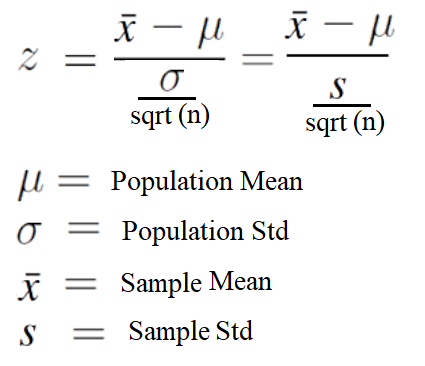

In [44]:
# Find z score for 4
# z = value - mean / std
physhlth_std = df['PHYSHLTH'].std()
n = len(df['PHYSHLTH'])

# Sample Mean Z-Score
physhlth_z = (physhlth_mean - 4)/(physhlth_std/(math.sqrt(n)))
physhlth_z

1.8631694383925375

In [96]:
physhlth_mean

4.085340919192817

In [45]:
# P Value of Sample Mean Z-Score
stats.norm.cdf(physhlth_z)

0.9687807843926909

Is there a statistically significant difference between men and women in the number of days a person feels phsyically ill?

$$
H_0 : p_m = p_f\\
H_A : p_m \neq p_f
$$

$$
\mu_m
$$

In [46]:
# Separate male and female DF's
male = df[df['SEX'] == 1]
female = df[df['SEX'] == 2]

In [47]:
# Male and female n, s, and x values
male_n = len(male)
female_n = len(female)
male_s = male['PHYSHLTH'].std()
female_s = female['PHYSHLTH'].std()
male_x = male['PHYSHLTH'].mean()
female_x = female['PHYSHLTH'].mean()
male_n, female_n, male_s, female_s, male_x, female_x

(15158,
 19366,
 8.230260880997333,
 8.715033970548701,
 3.700971791064921,
 4.3852784093913595)

In [48]:
# Degrees of Freedom
mf_deg_f = len(male) + len(female) - 2
mf_deg_f

34522

In [49]:
# Comparing two Pop means
# Calculate sp
sp = math.sqrt(((male_n-1)*(male_s**2) + (female_n-1)*(female_s**2)) / mf_deg_f)
#((male_n-1)*(male_s**2) + (female_n-1)*(female_s**2)) / (male_n+female_n-2)

In [50]:
# Comparing two Pop means
# Test Statistic
(male_x - female_x) / (sp*(math.sqrt(1/male_n + 1/female_n)))

-7.418675290367232

In [51]:
stats.ttest_ind(male['PHYSHLTH'], female['PHYSHLTH'])

Ttest_indResult(statistic=nan, pvalue=nan)

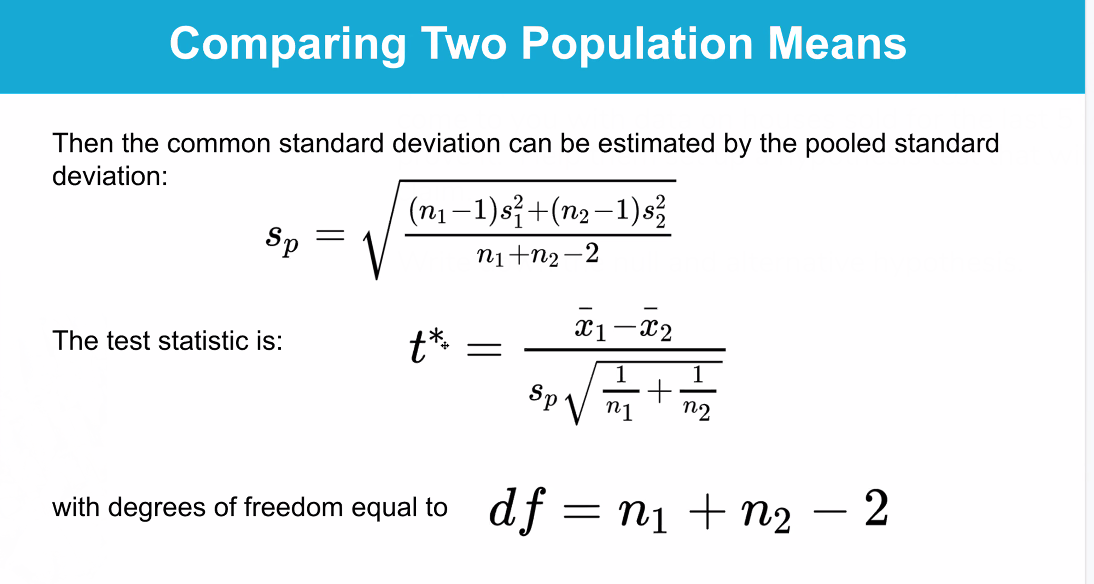

In [52]:
# Perform a statistical test to determine if there statistically significant difference in physical health of people from the three states. 

$$
H_0 : p_{ct} = p_{nj} = p_{ny}\\
H_A : H_0 = False
$$

In [53]:
# Separate state DF's

CT = df[df['_STATE'] == 'CT']
NJ = df[df['_STATE'] == 'NJ']
NY = df[df['_STATE'] == 'NY']

In [54]:
# State physical health data
CT_hlth = CT['PHYSHLTH'].dropna(inplace=True)
NJ_hlth = NJ['PHYSHLTH'].dropna(inplace=True)
NY_hlth = NY['PHYSHLTH'].dropna(inplace=True)

/Users/eric/opt/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:4303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(result)


In [55]:
# ANOVA of physical health by state
stats.f_oneway(CT['PHYSHLTH'], NJ['PHYSHLTH'], NY['PHYSHLTH'])

F_onewayResult(statistic=18.558644605907094, pvalue=8.800607044147037e-09)

### Statistic > p value
### Reject Null

### The following questions are regarding the  `CHRONIC` variable.
- What is the probability of drawing this sample proportion if chronically true population proportion is 0.10?
- Is there a statistically significant difference in the percentage of men and women who are chronically sick?
- Perform a statistical test to determine if there statistically significant difference is physical health of people from the three states.

What is the probability of drawing this sample proportion if chronically true population proportion is 0.10?

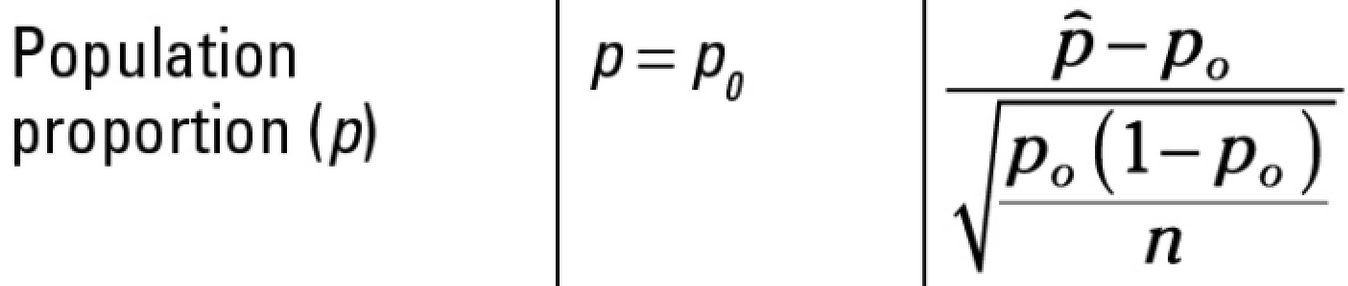

In [56]:
# Find z score for 4
# z = value - mean / std

# Set mean, n, population p, std
chron_mean = df['CHRONSICK'].mean()
n=len(df['CHRONSICK'])
p_pop = .10
chron_std = df['CHRONSICK'].std()

In [57]:
# Find Z Score
chron_z = (chron_mean - p_pop)/math.sqrt((p_pop*(1-p_pop))/n)
chron_z

15.62980422596022

In [58]:
# P value for Z Score
stats.norm.cdf(chron_z)

1.0

In [59]:
# Is there a statistically significant difference in the percentage of men and women who are chronically sick?

$$
\hat{p}=\dfrac{Y_1+Y_2}{n_1+n_2}
\\\ \\\ 
Z=\dfrac{(\hat{p}_1-\hat{p}_2)-0}{\sqrt{\hat{p}(1-\hat{p})\left(\dfrac{1}{n_1}+\dfrac{1}{n_2}\right)}}
$$

$$
H_0 : p_m = p_f\\
H_A : p_m \neq p_f
$$

In [60]:
# Male and female chronically sick proportions
males_sum = male['CHRONSICK'].sum()
males_pct = males_sum / len(male)

females_sum = female['CHRONSICK'].sum()
females_pct = females_sum / len(female)

In [61]:
# Male vs female

# Portion of Success
p_m_f = (males_sum + females_sum) / (len(male) + len(female))
p_m_f

0.12521724018074384

In [62]:
# Z Score
sick_z = (males_pct - females_pct) / math.sqrt(p_m_f * (1 - p_m_f) * (1 / len(male) + 1 / len(female)))
sick_z

-6.227147850941022

In [63]:
# P Value for difference of male and female sick proportions
stats.norm.cdf(sick_z)

2.375014124107125e-10

In [64]:
# Check work with stats.ttest_ind
stats.ttest_ind(male['CHRONSICK'], female['CHRONSICK'])

Ttest_indResult(statistic=-6.230467491612668, pvalue=4.704055436298023e-10)

### P Value < 0.05
### Reject Null

Perform a statistical test to determine if there statistically significant difference is physical health of people from the three states.

$$
H_0 : p_{ct} = p_{nj} = p_{ny}\\
H_A : H_0 = False
$$

In [65]:
# Chronically sick totals per state
CT_chron = CT['CHRONSICK'].sum()
CT_not = len(CT) - CT_chron
NJ_chron = NJ['CHRONSICK'].sum()
NJ_not = len(NJ) - NJ_chron
NY_chron = NY['CHRONSICK'].sum()
NY_not = len(NY) - NY_chron

In [66]:
# Contingency Table of chronically sick totals
chron_table = [[CT_chron, NJ_chron, NY_chron], [CT_not, NJ_not, NY_not]]

In [67]:
# Set stat, p, dof, expected
stat, p, dof, expected = chi2_contingency(chron_table)
print('dof=%d' % dof)
print(expected)

dof=2
[[ 1325.91367781  1466.16899696  1533.91732523]
 [ 9262.08632219 10241.83100304 10715.08267477]]


In [68]:
# interpret test-statistic
confidence = 0.95
critical = chi2.ppf(confidence, dof)
critical, confidence, stat

(5.991464547107979, 0.95, 27.91947386458293)

Test Stat > Critical

Reject Null

# 10. Independent Investigation

Now that you have invesitgated physical health and chronic sickness and their relationships with states and gender, you will conduct a similar investigation with variables of your choosing. 

Select a continuous dependent varaible and a binary dependent variable that you would like to investigate. Then select a categorical independent variable with at least 3 groups and for which you will test to see if the response to the independent variable affects outcomes of the dependent variable.

For your continuous dependent variable perform the following:
  - Determine the sample mean and sample standard deviation
  - Create a confidence interval for a population mean.
  - Perform a two-sample test of means for gender.
  - Perform a one-way ANOVA using your categorical independent variable.

Num of times french fries eaten per day by state

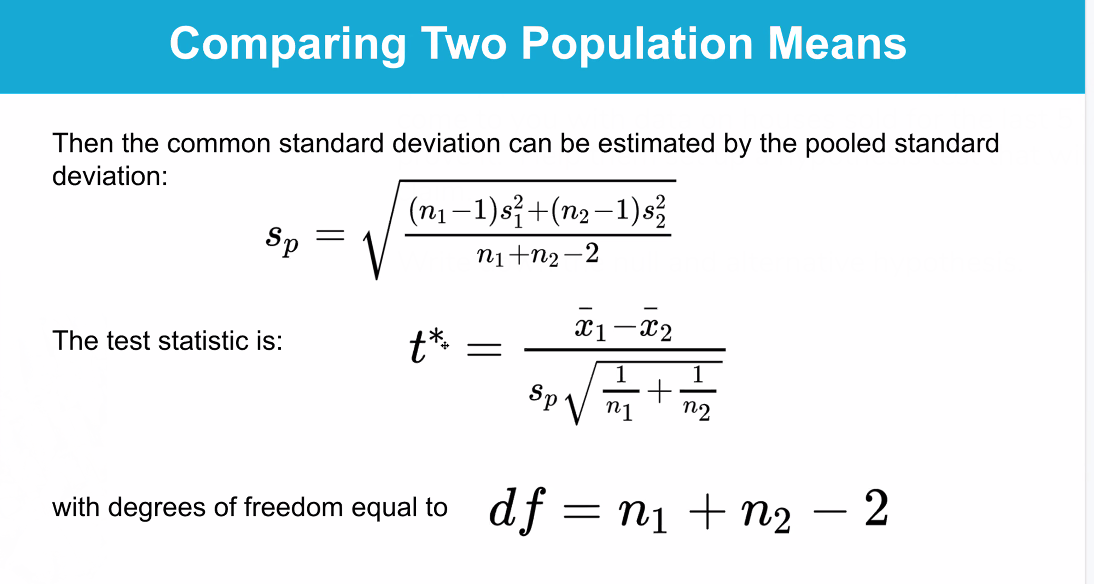

$$
H_0 : p_{ct} = p_{nj} = p_{ny}\\
H_A : H_0 = False
$$

In [69]:
# Create fries DF
fr_df = df

# Remove null values
fr_df['FRNCHDA_'] = fr_df['FRNCHDA_'].map(lambda x: x*.01)
fr_df['FRNCHDA_'].dropna(inplace=True)

In [70]:
# Determine the sample mean and sample standard deviation
fr_df['FRNCHDA_'].describe()

count    31636.000000
mean         0.154440
std          0.326509
min          0.000000
25%          0.020000
50%          0.070000
75%          0.140000
max         20.000000
Name: FRNCHDA_, dtype: float64

In [71]:
# Create a confidence interval for a population mean.
# x bar
fries_mean = fr_df['FRNCHDA_'].mean()
# n
fries_sum = fr_df['FRNCHDA_'].sum()
# sigma
fries_std = fr_df['FRNCHDA_'].std()

fries_low = round(fries_mean - 1.96 * (fries_std/(fries_sum**.5)), 2)
fries_high = round(fries_mean + 1.96 * (fries_std/(fries_sum**.5)), 2)

(fries_low, fries_high)

(0.15, 0.16)

Perform a two-sample test of means for gender.

$$
H_0 : p_m = p_f\\
H_A : p_m \neq p_f
$$

In [72]:
# Create male and female n, std, x data
fr_male_n = len(male)
fr_female_n = len(female)
fr_male_s = male['FRNCHDA_'].std()
fr_female_s = female['FRNCHDA_'].std()
fr_male_x = male['FRNCHDA_'].mean()
fr_female_x = female['FRNCHDA_'].mean() 

In [73]:
# Calculate Pooled std
fr_sp = math.sqrt(((fr_male_n-1)*(fr_male_s**2) + (fr_female_n-1)*(fr_female_s**2)) / (fr_male_n+fr_female_n-2)) 
fr_sp

32.48829988439576

In [74]:
# Calculate T*
fr_t = (fr_male_x - fr_female_x) / (fr_sp*(math.sqrt(1/fr_male_n + 1/fr_female_n)))
fr_t

19.65813371847603

Perform a one-way ANOVA using your categorical independent variable.

In [75]:
len(fr_df['FRNCHDA_']), len(fr_df['_STATE'])

(31636, 34545)

In [76]:
stats.f_oneway(fr_df['FRNCHDA_'][fr_df['_STATE']=='CT'],
               fr_df['FRNCHDA_'][fr_df['_STATE']=='NJ'],
               fr_df['FRNCHDA_'][fr_df['_STATE']=='NY'])

F_onewayResult(statistic=1.281253813448252, pvalue=0.27770332241623896)

In [77]:
# Method using statsmodels, (requires equal column lengths)
# fr_anova = ols('FRNCHDA_~_STATE',data=fr_df).fit()
# fr_anova.summary()

P value > .05

Don't Reject Null

Select/create a binary variable from the survey questions as you dependent variable and perform the following:
  - Create a confidence interval for a population proportion.
  - Perform a two proportions z-test using gender.
  - Perform a Chi-Square test using your categorical independent variable.

$$
\hat{p}=\dfrac{Y_1+Y_2}{n_1+n_2}
\\\ \\\ 
Z=\dfrac{(\hat{p}_1-\hat{p}_2)-0}{\sqrt{\hat{p}(1-\hat{p})\left(\dfrac{1}{n_1}+\dfrac{1}{n_2}\right)}}
$$

$$
H_0 : p_{ct} = p_{nj} = p_{ny}\\
H_A : H_0 = False
$$

In [78]:
# Create pneumonia DF
pn_df = df
# Drop irrelevant answers
p_dict = {9:np.nan}
pn_df['_PNEUMO2'].replace(p_dict, inplace=True)
pn_df['_PNEUMO2'].dropna(inplace=True)
# Replace 2 answers with 0
pn_df['_PNEUMO2'].replace({2:0}, inplace=True)

In [79]:
# Pneumonia data per state
pn_CT = pn_df[pn_df['_STATE'] == 'CT']
pn_NJ = pn_df[pn_df['_STATE'] == 'NJ']
pn_NY = pn_df[pn_df['_STATE'] == 'NY']

In [80]:
#Create a confidence interval for a population proportion. - '_PNEUMO2'

# x bar
pn_mean = pn_df['_PNEUMO2'].mean()
# n
pn_sum = pn_df['_PNEUMO2'].sum()
# sigma
pn_std = pn_df['_PNEUMO2'].std()

# Confidence Interval
pn_low = round(pn_mean - 1.96 * (pn_std/(pn_sum**.5)), 2)
pn_high = round(pn_mean + 1.96 * (pn_std/(pn_sum**.5)), 2)
(pn_low, pn_high)

(0.74, 0.76)

In [81]:
#Perform a two proportions z-test using gender.
pn_male = pn_df[pn_df['SEX'] == 1]
pn_males_sum = pn_male['_PNEUMO2'].sum()
pn_males_pct = pn_males_sum / len(pn_male)

pn_female = pn_df[pn_df['SEX'] == 2]
pn_females_sum = pn_female['_PNEUMO2'].sum()
pn_females_pct = pn_females_sum / len(pn_female)

In [82]:
# Portion of Success
pn_m_f = (pn_males_sum + pn_females_sum) / len(pn_df)
# Z Score
pn_z = (pn_males_pct - pn_females_pct) / math.sqrt(pn_m_f * (1 - pn_m_f) * (1 / len(pn_male) + 1 / len(pn_female)))
pn_m_f, pn_z

(0.3738022868721957, -10.659367429516726)

In [83]:
# P value
stats.norm.cdf(pn_z)

7.883307345315394e-27

In [84]:
# Method using Two Sample T-Test
stats.ttest_ind(pn_df['_PNEUMO2'][pn_df['SEX'] == 1], pn_df['_PNEUMO2'][pn_df['SEX'] == 2])

Ttest_indResult(statistic=-3.8246087762735628, pvalue=0.00013175117927729155)

P value < .05

Reject Null

In [85]:
#Perform a Chi-Square test using your categorical independent variable.

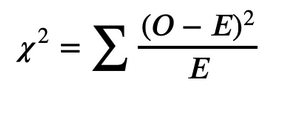

$$
H_0 : p_{ct} = p_{nj} = p_{ny}\\
H_A : H_0 = False
$$

Manual Method

In [86]:
# Set Pneumonia vaccine sums per state
pn_ct_sum = pn_CT['_PNEUMO2'].sum()
pn_nj_sum = pn_NJ['_PNEUMO2'].sum()
pn_ny_sum = pn_NY['_PNEUMO2'].sum()
ct_nope = len(pn_CT) - pn_ct_sum
nj_nope = len(pn_NJ) - pn_nj_sum
ny_nope = len(pn_NY) - pn_ny_sum

In [87]:
# Create Pneumonia Chi Squared DF
pn_chi = {'CT': [pn_ct_sum, ct_nope], 'NJ': [pn_nj_sum, nj_nope], 'NY': [pn_ny_sum, ny_nope]}
pn_chi = pd.DataFrame(pn_chi, index=['pneumo','no_pneumo'])
pn_chi

,CT,NJ,NY
pneumo,4003.0,4853.0,4061.0
no_pneumo,6585.0,6855.0,8188.0


In [88]:
# Create Rows, Columns of Contingency Table
row1 = pn_chi.iloc[0,:].sum()
row2 = pn_chi.iloc[1,:].sum()
col1 = pn_chi.iloc[:,0].sum()
col2 = pn_chi.iloc[:,1].sum()
col3 = pn_chi.iloc[:,2].sum()
sample = sum([row1, row2])

In [89]:
# Calculate Degrees of Freedom
pn_deg_f = (2 - 1) * (3 - 1)
pn_deg_f

2

In [90]:
# Calculate Chi-Squared Test Statistic
x_squared = (((pn_chi.iloc[0,0] - (row1*col1/sample))**2)/(row1*col1/sample) +
             ((pn_chi.iloc[0,1] - (row1*col2/sample))**2)/(row1*col2/sample) +
             ((pn_chi.iloc[0,2] - (row1*col3/sample))**2)/(row1*col3/sample) +
             ((pn_chi.iloc[1,0] - (row2*col1/sample))**2)/(row2*col1/sample) +
             ((pn_chi.iloc[1,1] - (row2*col2/sample))**2)/(row2*col2/sample) +
             ((pn_chi.iloc[1,2] - (row2*col3/sample))**2)/(row2*col3/sample))
x_squared

177.1349593082242

In [91]:
# Check Test Statistic in Chi Squared Table, set Critical Value
pn_crit_val = 5.991
pn_crit_val

5.991

scipy method

In [92]:
# Contingency Table of chronically sick totals
pn_table = [[pn_ct_sum, pn_nj_sum, pn_ny_sum], [ct_nope, nj_nope, ny_nope]]

In [93]:
# Set stat, p, dof, expected
pn_stat, pn_p, pn_dof, pn_expected = chi2_contingency(pn_table)
print('dof=%d' % pn_dof)
print(pn_expected)

dof=2
[[3959.04460848 4377.8328557  4580.12253582]
 [6628.95539152 7330.1671443  7668.87746418]]


In [94]:
# interpret test-statistic
pn_confidence = 0.95
pn_critical = chi2.ppf(pn_confidence, pn_dof)
pn_critical, pn_confidence, pn_stat

(5.991464547107979, 0.95, 177.1349593082242)

P value > Critical Value

Reject Null